## Importing the necessary libraries

In [1]:
import os
import zipfile
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack, signal
from scipy.fftpack.realtransforms import dct
from scipy.stats import skew, kurtosis
from datetime import datetime, timedelta

In [2]:
DATASET_PATH = '../Datasets/Accelerometer Data + TAC'
ACCELEROMETER_DATA = 'all_accelerometer_data_pids_13.csv'

if not os.path.exists(f'{DATASET_PATH}/{ACCELEROMETER_DATA}'):
    with zipfile.ZipFile(f'{DATASET_PATH}/data.zip', "r") as zip_ref:
        zip_ref.extractall(f'{DATASET_PATH}/')

## Data Extraction and Cleaning

### Accelerometer Data

Accelerometer data was collected from smartphones at a sampling rate of 40Hz. => T = $\frac{1}{40}$ s = 25ms.

In [3]:
all_accelerometer_df = pd.read_csv(f'{DATASET_PATH}/{ACCELEROMETER_DATA}')
all_accelerometer_df.rename(columns={'time': 'timestamp'}, inplace=True)
all_accelerometer_df.head()

,timestamp,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


It can be seen that there're a few rows with timestamp = 0 and they need to be removed.

In [4]:
print(f'Shape of all_accelerometer_df: {all_accelerometer_df.shape}')
# Drop null values
all_accelerometer_df.dropna(inplace=True)
# Drop rows with timestamp = 0
all_accelerometer_df = all_accelerometer_df[all_accelerometer_df['timestamp'] != 0]
print(f'Shape of all_accelerometer_df after cleaning: {all_accelerometer_df.shape}')

Shape of all_accelerometer_df: (14057567, 5)
Shape of all_accelerometer_df after cleaning: (14057565, 5)


Grouping the dataframe by both pid and timestamp to get the accelerometer data for each participant.

In [5]:
all_accelerometer_df.groupby(['pid', 'timestamp']).first()

x       y       z
pid    timestamp                            
BK7610 1493735870653  0.1261 -0.0078 -0.0243
       1493735870679  0.1336 -0.0697 -0.0446
       1493735870703  0.1443 -0.0474 -0.0447
       1493735870729  0.1255 -0.0038  0.0111
       1493735870753  0.1076  0.0032  0.0276
...                      ...     ...     ...
SF3079 1493790825484  0.0169  0.0426  0.2114
       1493790825487 -0.4330  0.1745 -0.1570
       1493790825489  0.1015  0.0213 -0.1760
       1493790825492  0.2091 -0.0084  0.0871
       1493790825495 -0.0067  0.0099  0.0959

[14056688 rows x 3 columns]

The timestamp is 13 digits long. Hence, they're Unix style timestamps. => time is in milliseconds.

In [5]:
# Group by pid to separate out data related to each participant
accelerometer_gb = all_accelerometer_df.groupby('pid')
# For each group, get the particular dataframe and reset the index
accelerometer_data = {pid: df.sort_values(by='timestamp', ignore_index=True).drop('pid', axis=1).reset_index(drop=True) for pid, df in accelerometer_gb}
pids = list(accelerometer_data.keys())
accelerometer_data[pids[0]].head()

,timestamp,x,y,z
0,1493735870653,0.1261,-0.0078,-0.0243
1,1493735870679,0.1336,-0.0697,-0.0446
2,1493735870703,0.1443,-0.0474,-0.0447
3,1493735870729,0.1255,-0.0038,0.0111
4,1493735870753,0.1076,0.0032,0.0276


Checking the frequency of the timestamps.

In [7]:
acc_time = accelerometer_data[pids[0]]['timestamp']
acc_time = acc_time - acc_time.min()
acc_time.head(10)

0      0
1     26
2     50
3     76
4    100
5    131
6    150
7    177
8    200
9    226
Name: timestamp, dtype: int64

Next, let's examine the lengths of the time-series data streams collected from various participants.

Text(0.5, 1.0, 'Length of data stream for each participant')

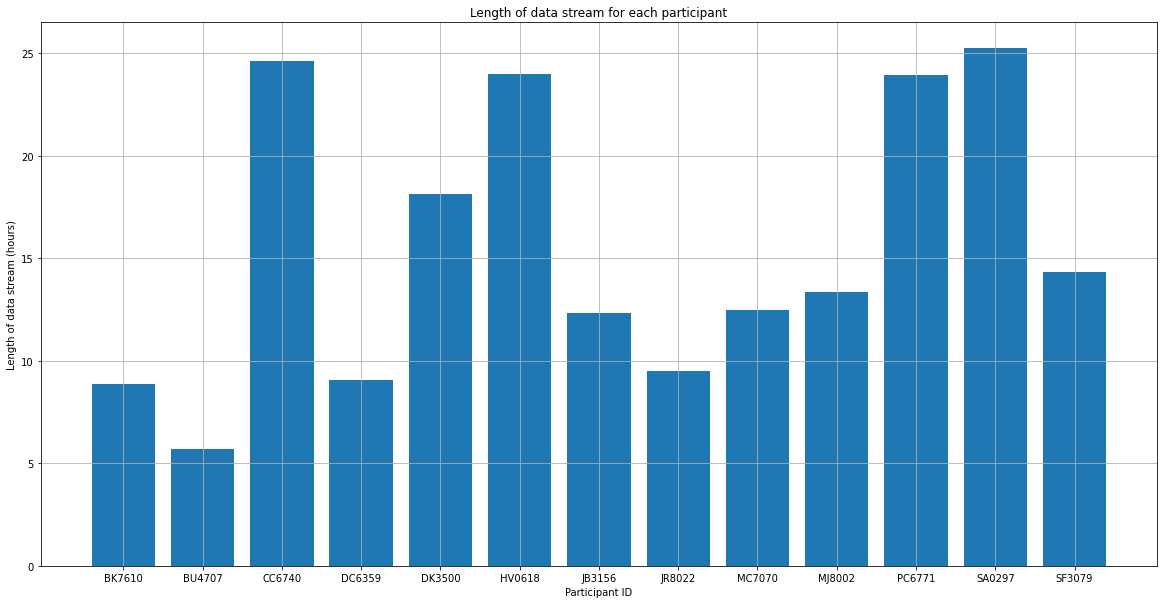

In [8]:
lengths = [(df['timestamp'].max() - df['timestamp'].min()) / (1000 * 60 * 60) for df in accelerometer_data.values()]
plt.figure(figsize=(20, 10))
plt.bar(pids, lengths)
plt.grid()
plt.xlabel('Participant ID')
plt.ylabel('Length of data stream (hours)')
plt.title('Length of data stream for each participant')

### Cleaned TAC Data

TAC data was collected using SCRAM ankle bracelets and was collected at 30 minute intervals. The cleaned TAC readings: 
1. Were processed with a zero-phase low-pass filter to smooth noise without shifting phase. 
2. Were shifted backwards by 45 minutes so the labels more closely match the true intoxication of the participant (since alcohol takes about 45 minutes to exit through the skin).

In [6]:
tac_readings = {}

for tac_file in os.listdir(f'{DATASET_PATH}/clean_tac'):
    tac_df = pd.read_csv(f'{DATASET_PATH}/clean_tac/{tac_file}')
    tac_df.sort_values(by='timestamp', inplace=True, ignore_index=True)
    # Drop null values
    tac_df.dropna(inplace=True)
    # Drop rows with timestamp = 0
    tac_df = tac_df[tac_df['timestamp'] != 0]
    tac_readings[tac_file.split('_')[0]] = tac_df

tac_readings[pids[0]].head()

,timestamp,TAC_Reading
0,1493718714,-0.000482
1,1493720697,0.001573
2,1493721027,0.002144
3,1493721357,0.000877
4,1493721686,-0.001145


The timestamp is 10 digits long. => time is in seconds. Let's check the frequency of the timestamps.

In [10]:
tac_time = tac_readings[pids[0]]['timestamp']
tac_time = tac_time - tac_time.min()
tac_time.head(10)

0       0
1    1983
2    2313
3    2643
4    2972
5    3302
6    3631
7    3960
8    4289
9    6118
Name: timestamp, dtype: int64

TAC has been measured in g/dl where 0.08 is the legal limit for intoxication while driving. If the TAC reading is less than 0.02, the participant is considered to be not drunk. If the TAC reading is greater than 0.02 and less than 0.08, the participant is considered to be sober. If it is greater than 0.08, the participant is considered to be intoxicated.

Text(0.5, 1.0, 'Length of data stream for each participant')

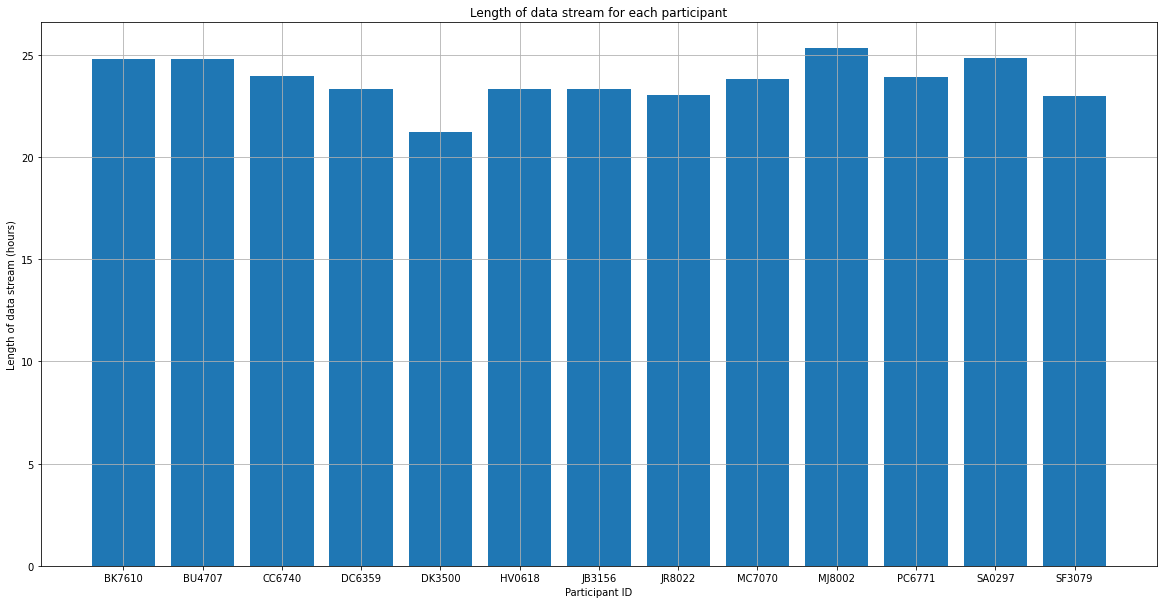

In [11]:
lengths = [(df['timestamp'].max() - df['timestamp'].min()) / (60 * 60) for df in tac_readings.values()]
plt.figure(figsize=(20, 10))
plt.bar(pids, lengths)
plt.grid()
plt.xlabel('Participant ID')
plt.ylabel('Length of data stream (hours)')
plt.title('Length of data stream for each participant')

## Data Exploration, Analysis and Visualization

### Time Domain

Plotting the first 1000 accelerometer data samples (x, y, z) vs time for the first 9 participants.

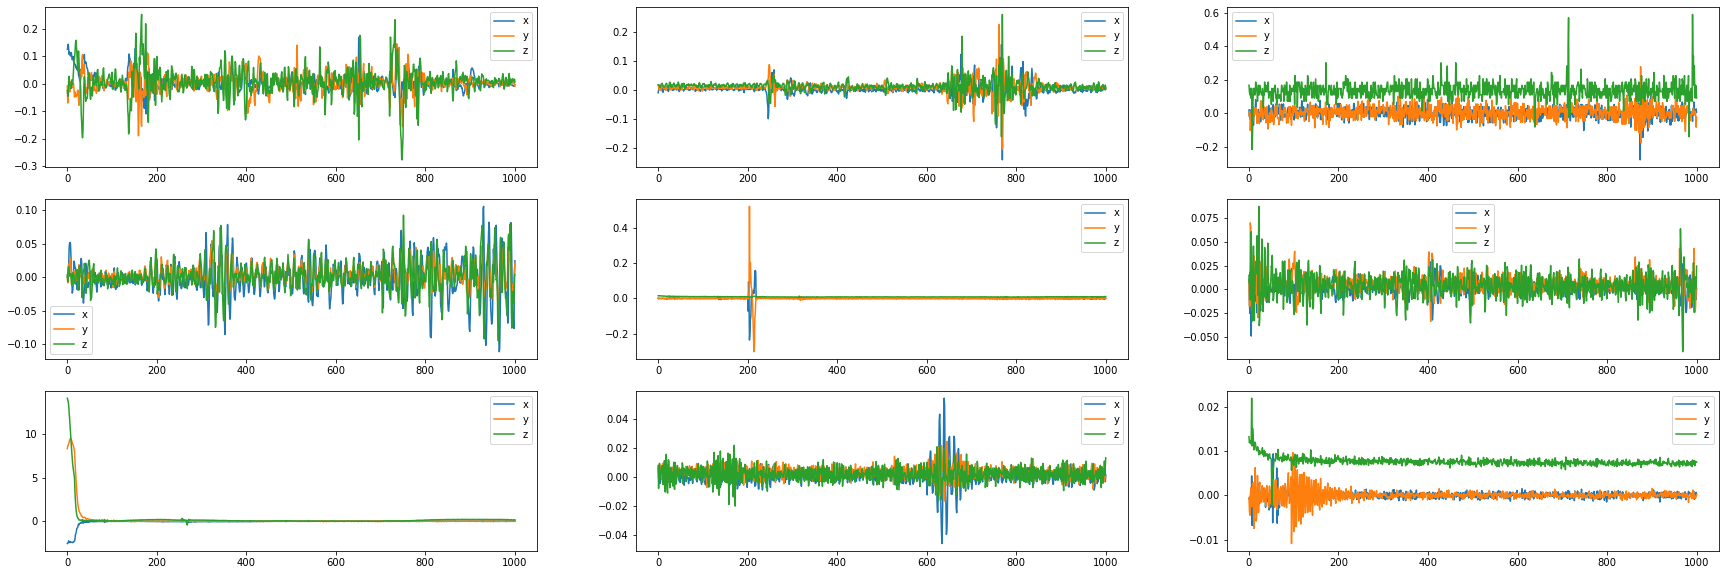

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(30, 10))
for i, pid in enumerate(pids[:9]):
    ax[i // 3, i % 3].plot(accelerometer_data[pid].drop('timestamp', axis=1).loc[:1000])
    ax[i // 3, i % 3].legend(['x', 'y', 'z'])

Plotting the TAC readings as well as the sober threshold (0.02 g/dl) for the first 9 participants.

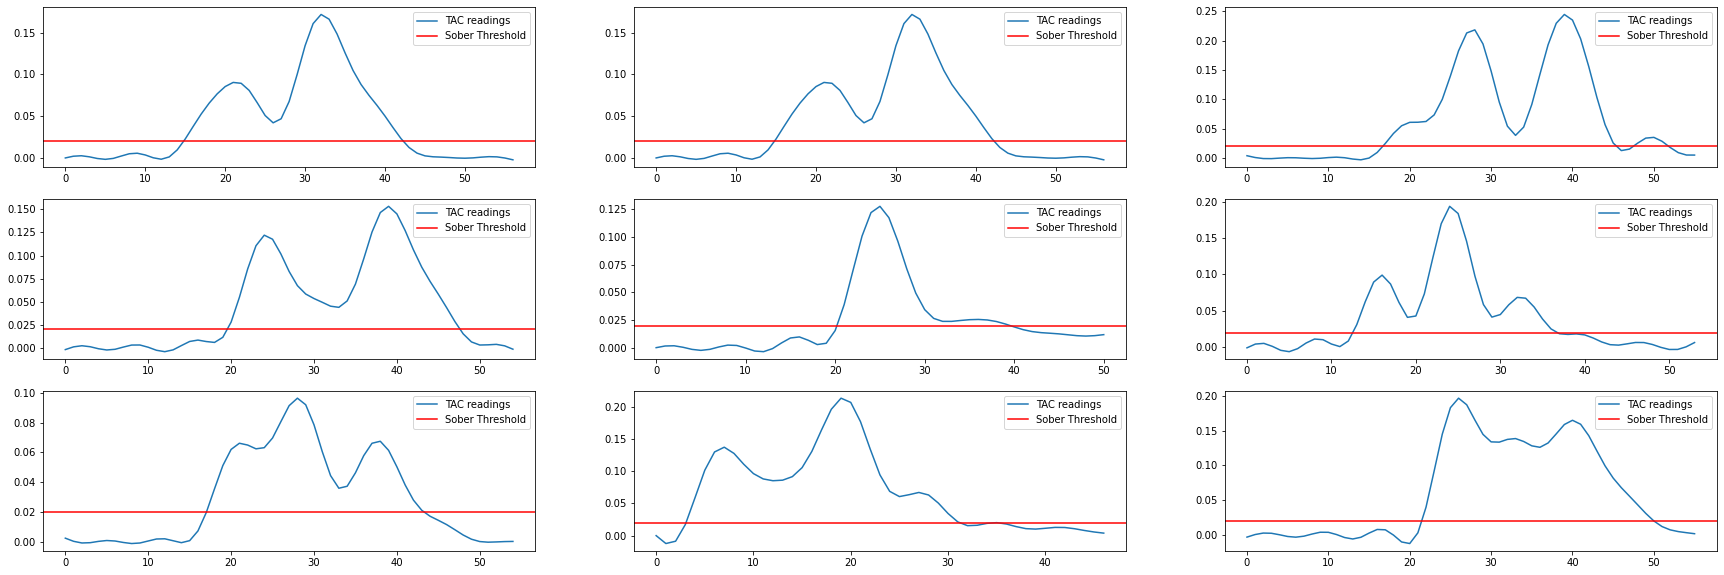

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(30, 10))
for i, pid in enumerate(pids[:9]):
    ax[i // 3, i % 3].plot(tac_readings[pid].drop('timestamp', axis=1))
    ax[i // 3, i % 3].axhline(y = 0.02, color='r', linestyle='-')
    ax[i // 3, i % 3].legend(['TAC readings', 'Sober Threshold'])

Extracting the groundtruth labels (sober - 1, not sober - 0) from the cleaned TAC data.

In [14]:
for pid in pids:
    accelerometer_data[pid]['ground_truth'] = [0] * accelerometer_data[pid].shape[0]
    for i, reading in tqdm(tac_readings[pid].iterrows(), desc=f"Processing {pid}'s TAC readings", total=len(tac_readings[pid])):
        if i != 0:
            t1, t2 = prev_reading['timestamp'], reading['timestamp']
            data = accelerometer_data[pid][(accelerometer_data[pid]['timestamp'] / 1000 >= t1) & (accelerometer_data[pid]['timestamp'] / 1000 < t2)]
            if not data.empty:
                if reading['TAC_Reading'] >= 0.02: accelerometer_data[pid].loc[data.index, 'ground_truth'] = 1
        prev_reading = reading

Processing SF3079's TAC readings: 100%|██████████| 54/54 [00:00<00:00, 95.23it/s]


Writing the accelerometer data with groundtruth labels of each participant to csv files.

In [15]:
if not os.path.exists(f'{DATASET_PATH}/participant_data'):
    os.mkdir(f'{DATASET_PATH}/participant_data')
for pid in tqdm(pids, desc='Writing data'):
    accelerometer_data[pid].to_csv(f'{DATASET_PATH}/participant_data/{pid}_accelerometer_data.csv', index=False)

Writing data: 100%|██████████| 13/13 [01:06<00:00,  5.10s/it]


Now, let's plot the class distribution among the participants.

C:\Users\Sathira\AppData\Local\Temp/ipykernel_21192/2984537886.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp, ignore_index=True)
C:\Users\Sathira\AppData\Local\Temp/ipykernel_21192/2984537886.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp, ignore_index=True)
C:\Users\Sathira\AppData\Local\Temp/ipykernel_21192/2984537886.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp, ignore_index=True)
C:\Users\Sathira\AppData\Local\Temp/ipykernel_21192/2984537886.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp, ignore_index=True)
C:\Users\Sathira\AppData

<AxesSubplot:xlabel='pid', ylabel='count'>

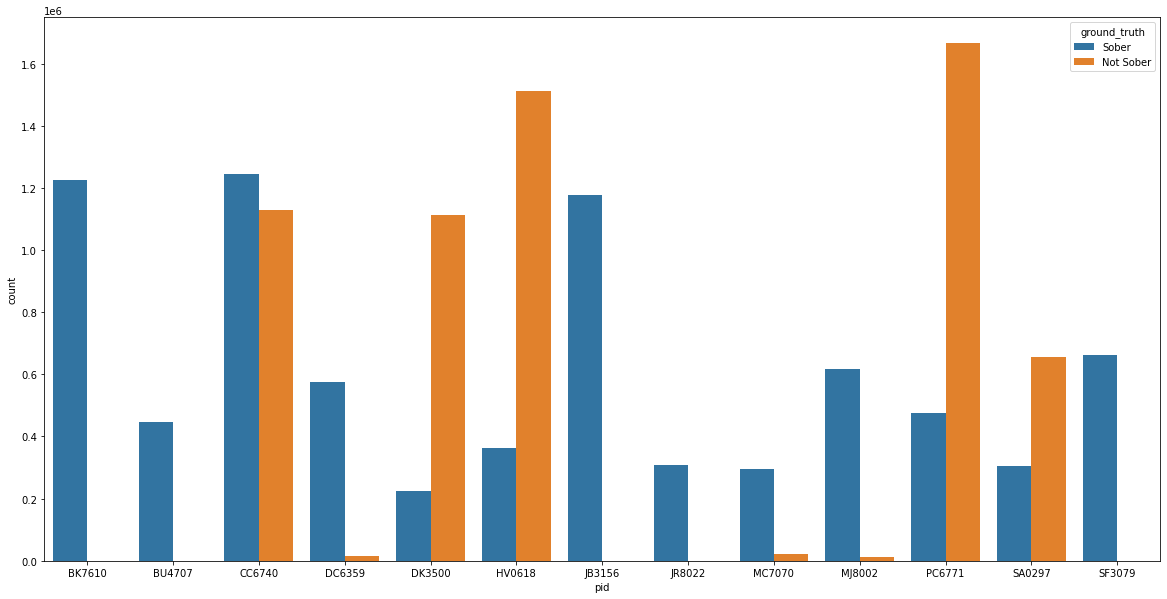

In [16]:
plt.figure(figsize=(20, 10))
df = accelerometer_data[pids[0]].drop(['timestamp', 'x', 'y', 'z'], axis=1)
df['pid'] = [pids[0]] * df.shape[0]
for pid in pids[1:]:
    temp = accelerometer_data[pid].drop(['timestamp', 'x', 'y', 'z'], axis=1)
    temp['pid'] = [pid] * temp.shape[0]
    df = df.append(temp, ignore_index=True)
df.replace({'ground_truth': {0: 'Not Sober', 1: 'Sober'}}, inplace=True)
sns.countplot(x='pid', data=df, hue='ground_truth')

Overall class distribution among the participants.

Text(0.5, 1.0, 'Sober vs Not Sober')

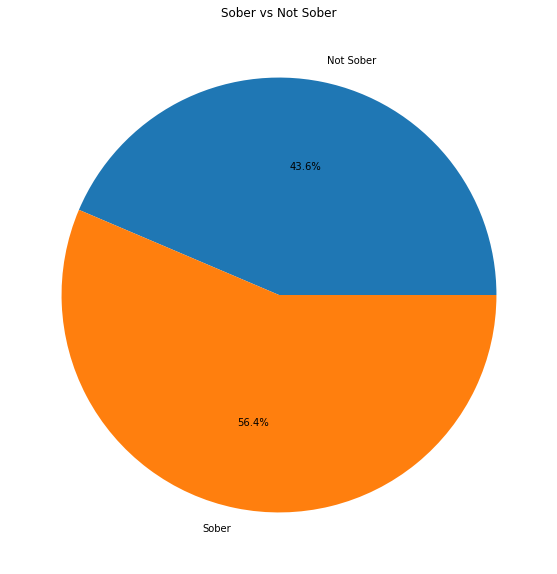

In [17]:
zeros, ones = 0, 0
for pid in pids:
    if 0 in accelerometer_data[pid]['ground_truth'].value_counts().index:
        zeros += accelerometer_data[pid]['ground_truth'].value_counts()[0]
    if 1 in accelerometer_data[pid]['ground_truth'].value_counts().index:
        ones += accelerometer_data[pid]['ground_truth'].value_counts()[1]
plt.figure(figsize=(20, 10))
plt.pie([zeros, ones], labels=['Not Sober', 'Sober'], autopct='%1.1f%%')
plt.title('Sober vs Not Sober')

In [18]:
accelerometer_data[pids[2]]['ground_truth'].value_counts()

1    1246074
0    1128620
Name: ground_truth, dtype: int64

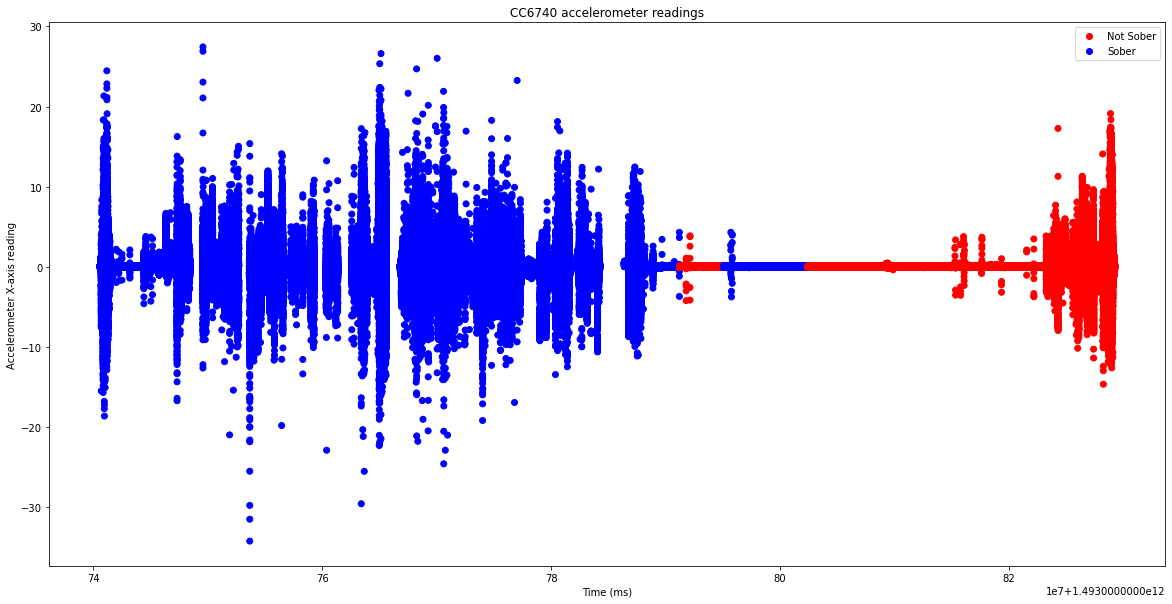

In [19]:
plt.figure(figsize=(20, 10))
scatter = plt.scatter(accelerometer_data[pids[2]]['timestamp'], accelerometer_data[pids[2]]['x'], c=accelerometer_data[pids[2]]['ground_truth'], cmap="bwr_r")
plt.xlabel('Time (ms)')
plt.ylabel('Accelerometer X-axis reading')
plt.title(f'{pids[2]} accelerometer readings')
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Sober', 'Sober'])

### Frequency Domain

Frequency spectrum of the whole stream of accelerometer data of the 3rd participant.

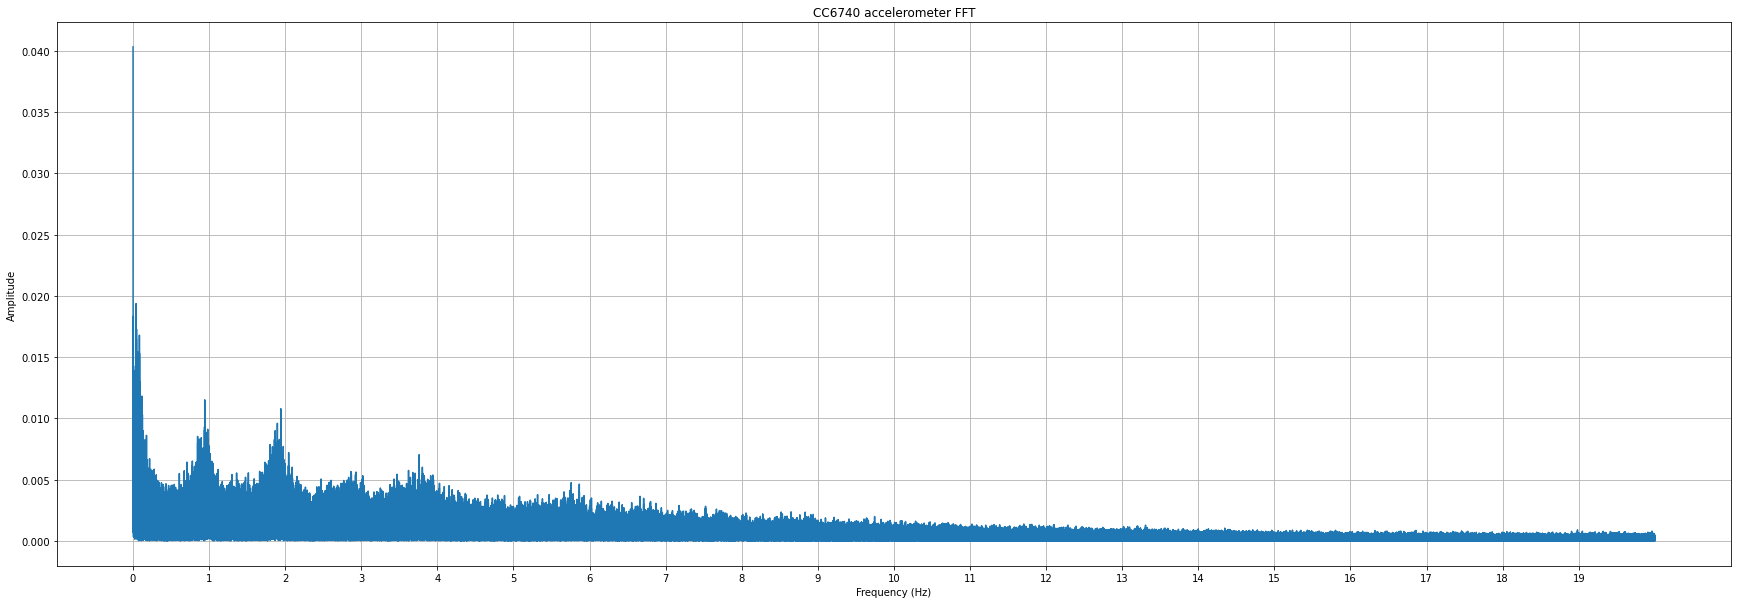

In [20]:
acc_x_fft = fftpack.fft(accelerometer_data[pids[2]]['x'].to_numpy())
freqs = (40 / 2) * np.linspace(0, 1, accelerometer_data[pids[2]]['x'].shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / accelerometer_data[pids[2]]['x'].shape[0]) * np.abs(acc_x_fft[:len(freqs)]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

From the above spectrum, it can be seen that the majority of the data is less than 3-4Hz.

Since the last few hours of the data of the 3rd participant is below the sober threshold, plotting the frequency spectrums of windows of several sizes (15 minutes, 5 minutes, 1 minute, 30 seconds and 10 seconds)

#### Frequency Analysis of Non Sober Windows

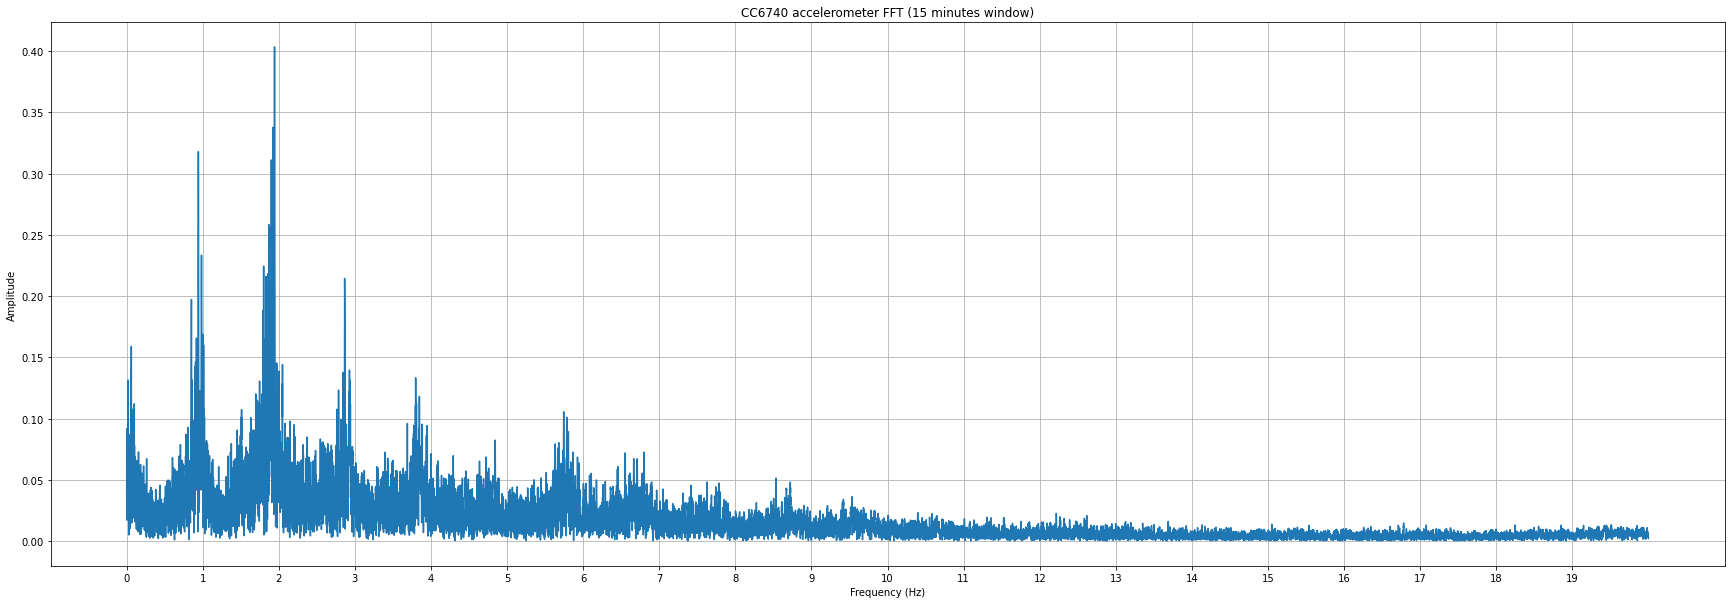

In [21]:
sampling_freq = 40
window_size = 15 * 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (15 minutes window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

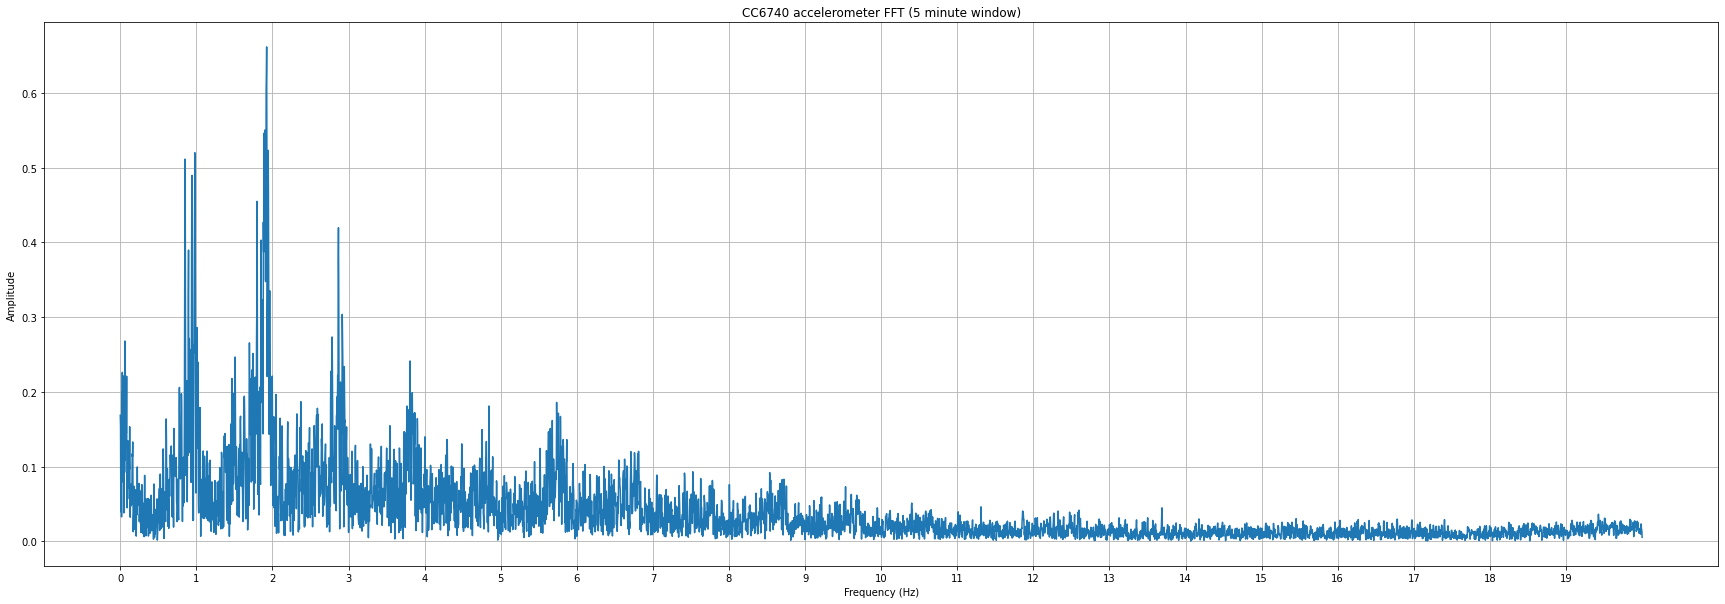

In [22]:
sampling_freq = 40
window_size = 5 * 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (5 minute window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

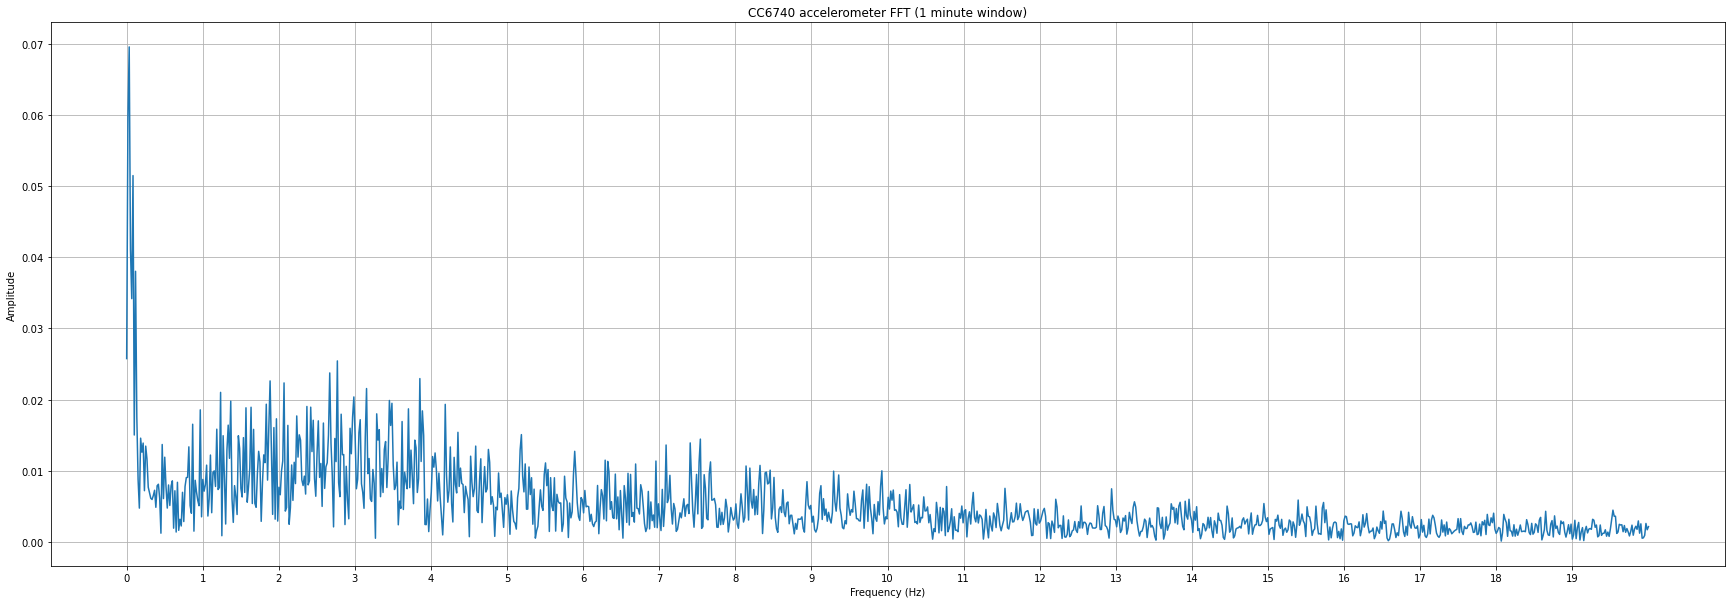

In [23]:
sampling_freq = 40
window_size = 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (1 minute window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

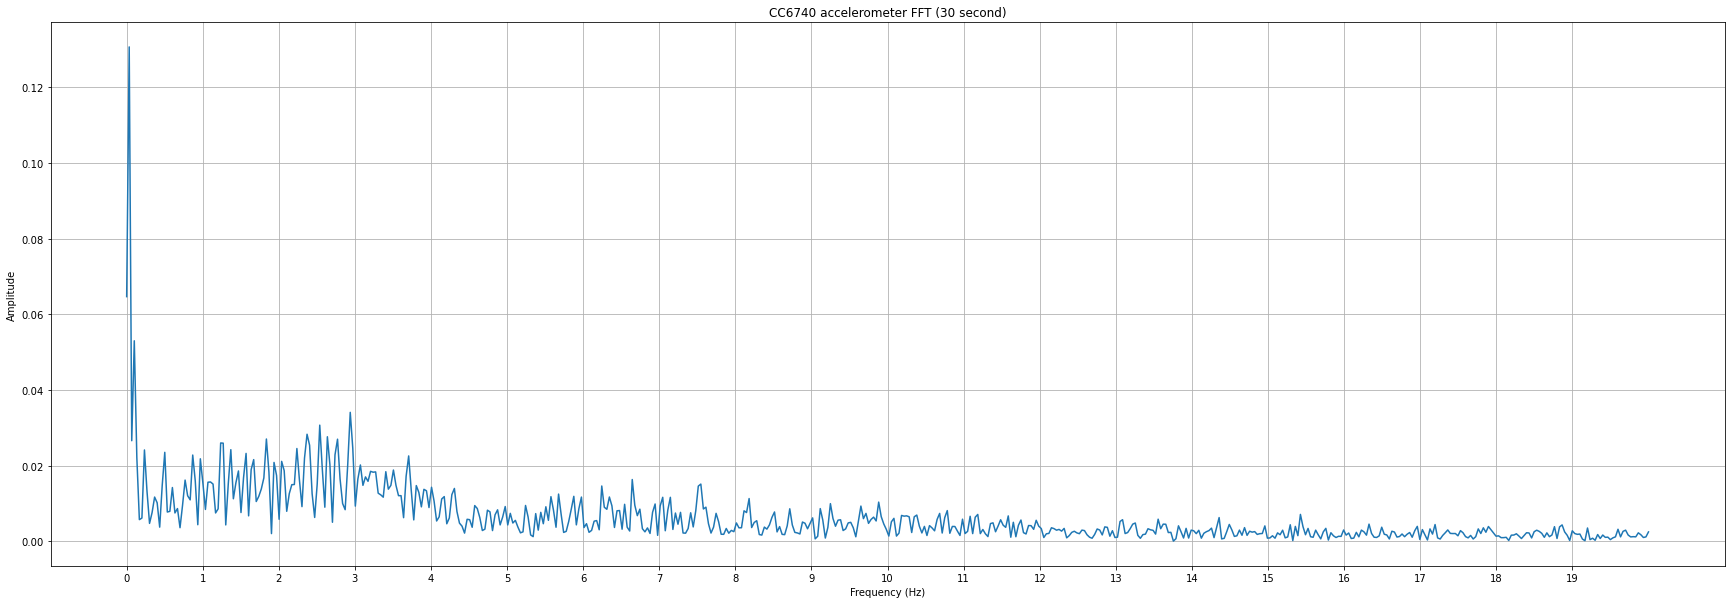

In [24]:
sampling_freq = 40
window_size = 30

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (30 second)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

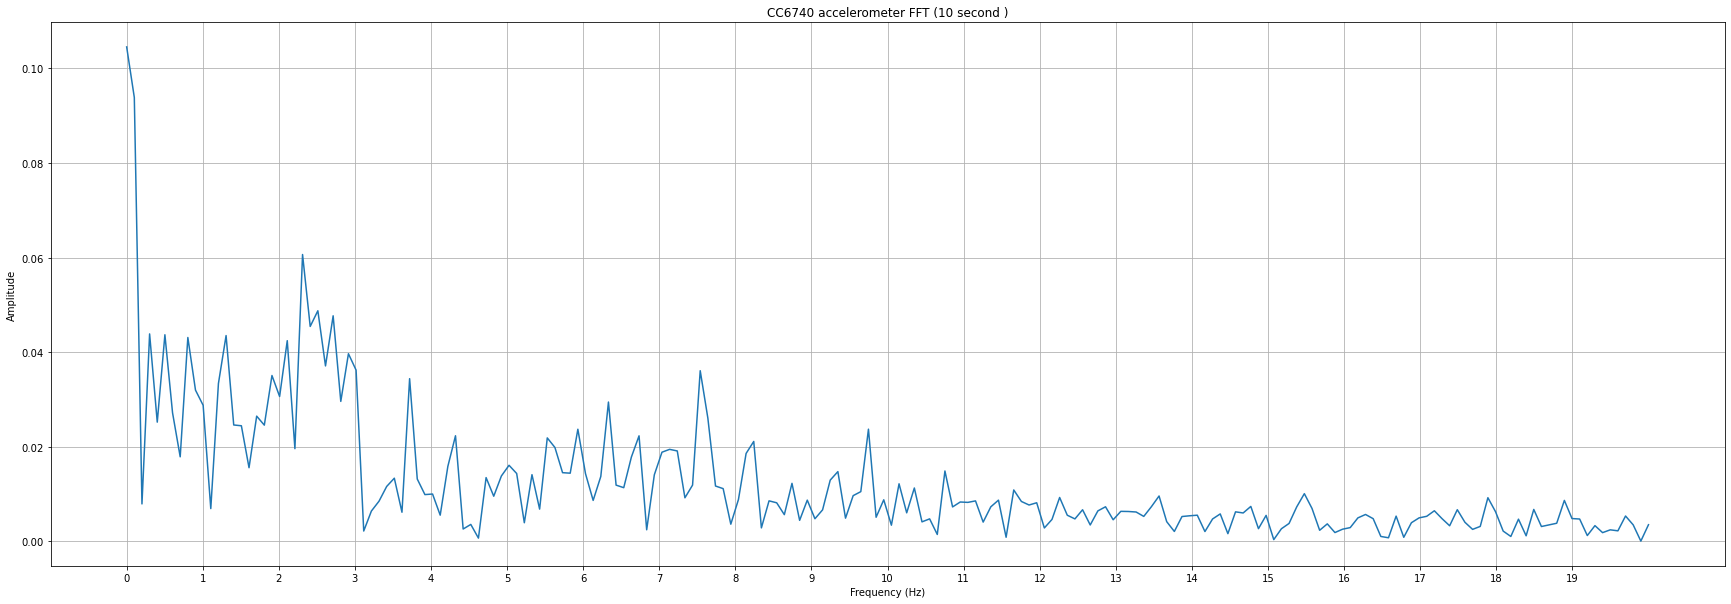

In [16]:
sampling_freq = 40
window_size = 10

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (10 second )')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

The frequency content is rich around 2Hz in the size 15 min and 5 min windows. => Walking is detected (average human walking frequency is about 2Hz)

Trying to filter out the other frequencies might remove the high frequency noise.

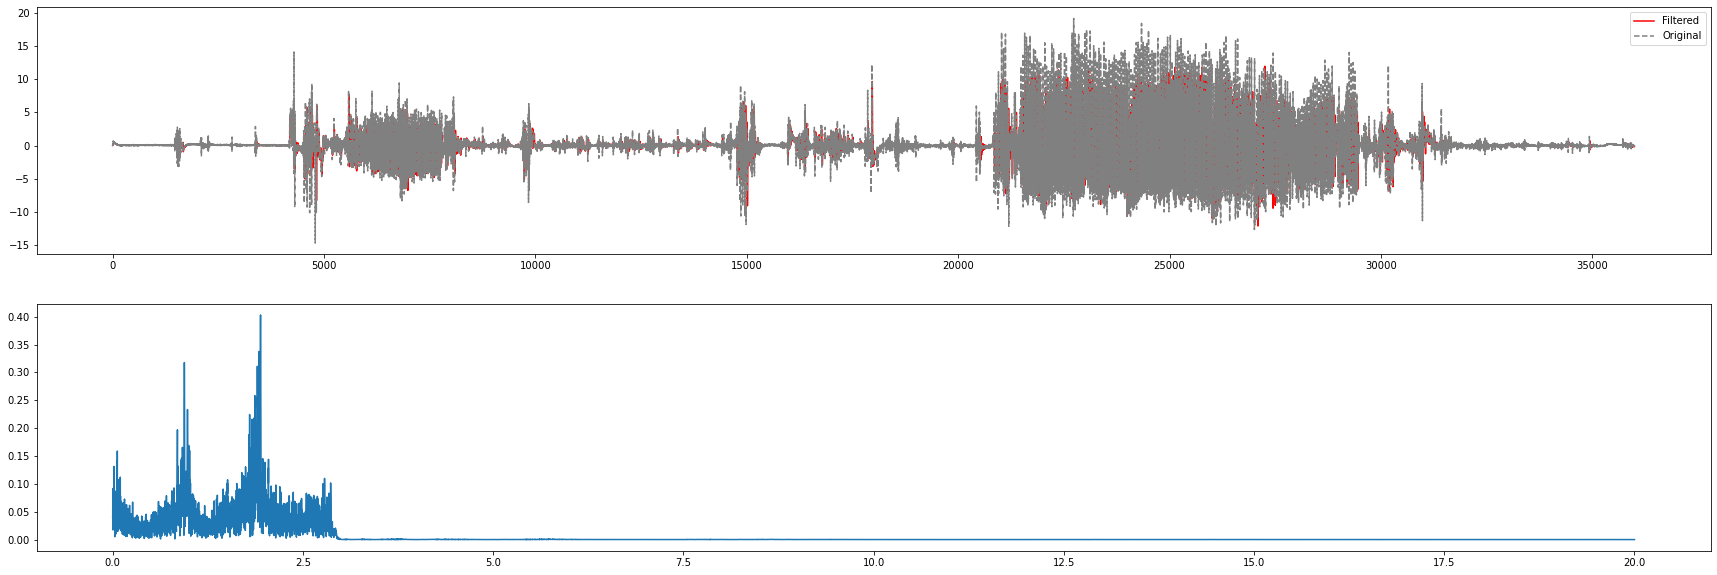

In [26]:
sampling_freq = 40
window_size = 15 * 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
# Lowpass chebyshev type II filter with fstop=3Hz, order=15
sos = signal.cheby2(15, 40, 3, 'low', fs=40, output='sos')
x_window_filtered = signal.sosfilt(sos, x_window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))
ax1.plot(x_window_filtered, 'r')
ax1.plot(x_window, '--', color='gray')
ax1.legend(['Filtered', 'Original'])

x_window_filtered_fft = fftpack.fft(x_window_filtered)
freqs = (40 / 2) * np.linspace(0, 1, x_window_filtered.shape[0] // 2)
ax2.plot(freqs, (2 / x_window_filtered.shape[0]) * np.abs(x_window_filtered_fft[:freqs.shape[0]]))

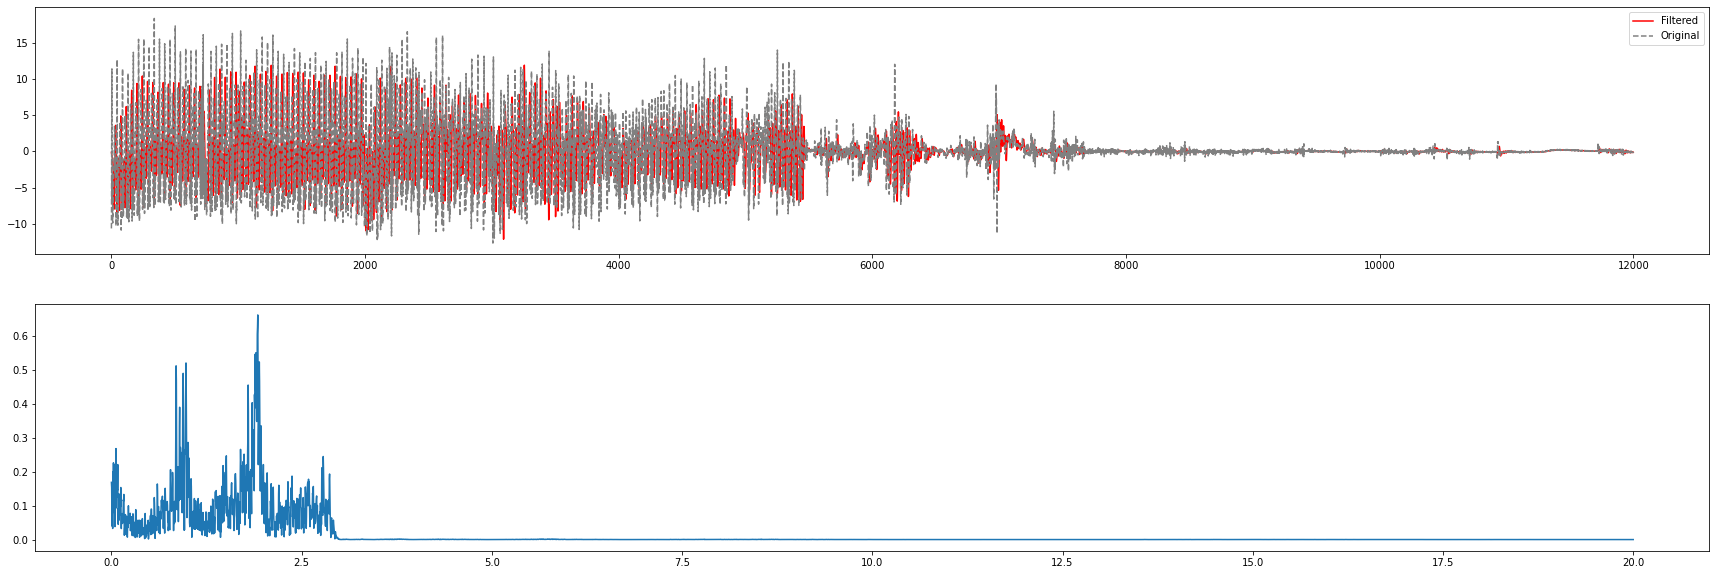

In [27]:
sampling_freq = 40
window_size = 5 * 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
# Lowpass chebyshev type II filter with fstop=3Hz, order=15
sos = signal.cheby2(15, 40, 3, 'low', fs=40, output='sos')
x_window_filtered = signal.sosfilt(sos, x_window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))
ax1.plot(x_window_filtered, 'r')
ax1.plot(x_window, '--', color='gray')
ax1.legend(['Filtered', 'Original'])

x_window_filtered_fft = fftpack.fft(x_window_filtered)
freqs = (40 / 2) * np.linspace(0, 1, x_window_filtered.shape[0] // 2)
ax2.plot(freqs, (2 / x_window_filtered.shape[0]) * np.abs(x_window_filtered_fft[:freqs.shape[0]]))

After filtering the signal, since the phase of the signal is shifted, the filtered signal will be delayed from the original signal. To measure the delay, cross-correlation can be used. Cross-correlation is a measure of similarity of two series as a function of time lag of one relative to the other. When the two series are equal, the cross-correlation becomes auto-correlation. The peak of auto correlation function is reached when the time delay is zero.

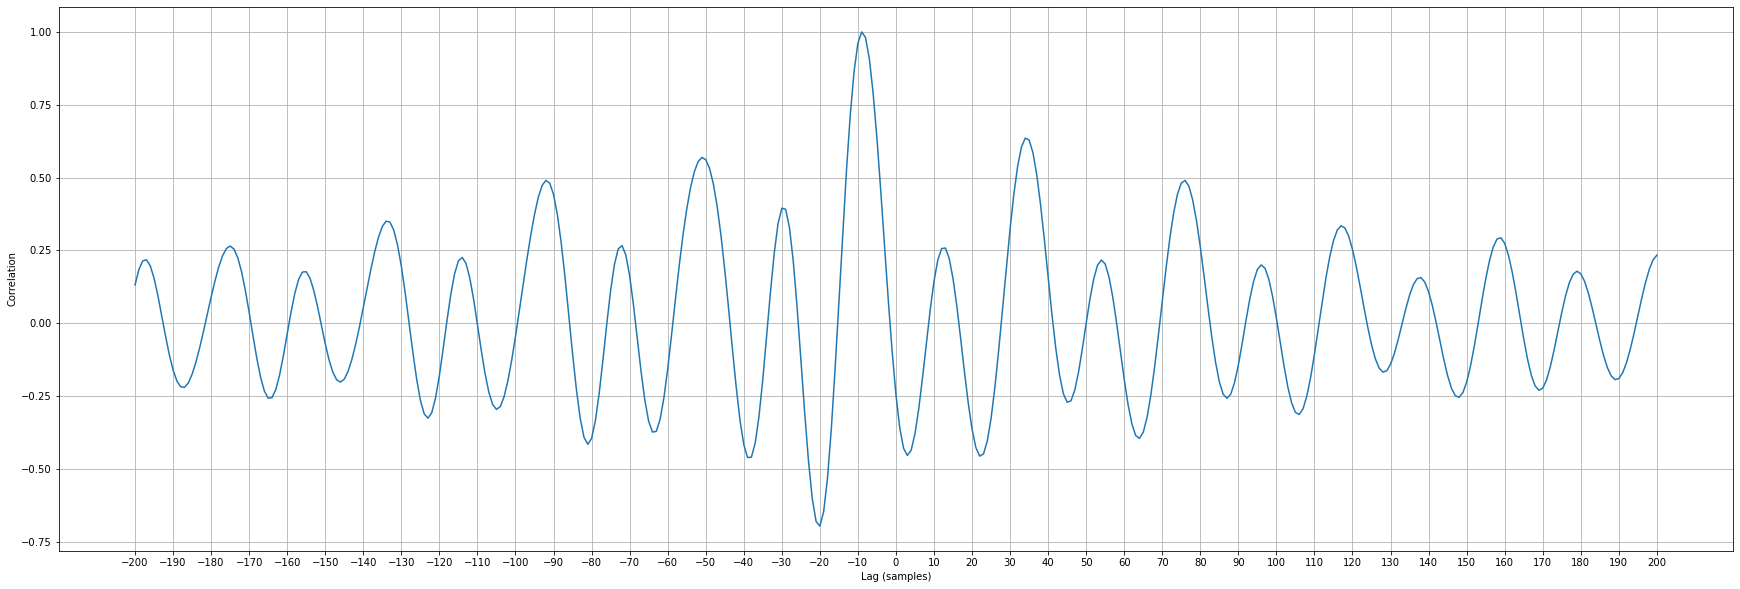

In [28]:
sampling_freq = 40
window_size = 5 * 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][l - sampling_freq * window_size:l].to_numpy()
sos = signal.cheby2(15, 40, 3, 'low', fs=40, output='sos')
x_window_filtered = signal.sosfilt(sos, x_window)
xcorr = signal.signaltools.correlate(x_window, x_window_filtered)
xcorr /= xcorr.max()
lags = signal.correlation_lags(x_window.shape[0], x_window_filtered.shape[0])
plt.figure(figsize=(30, 10))
# Zooming in on the middle of the correlation function
plt.plot(lags[lags.shape[0] // 2 - 200:lags.shape[0] // 2 + 201], xcorr[lags.shape[0] // 2 - 200:lags.shape[0] // 2 + 201])
plt.xticks(np.arange(-200, 201, 10))
plt.xlabel('Lag (samples)')
plt.ylabel('Correlation')
plt.grid()

The peak of the cross-correlation is at around -10 samples behind. Hence the delay is -10 samples => -10 / 40 = -0.25 seconds (Can be ignored since the delay is negligible).

The time delay was also tested for multiple windows of different sizes and still the delay was found to be in the order of 1 second.

#### Frequency Analysis of Sober Windows

Frequency spectrum of the data stream of the 3rd participant after 2 hours until next non-sober window.

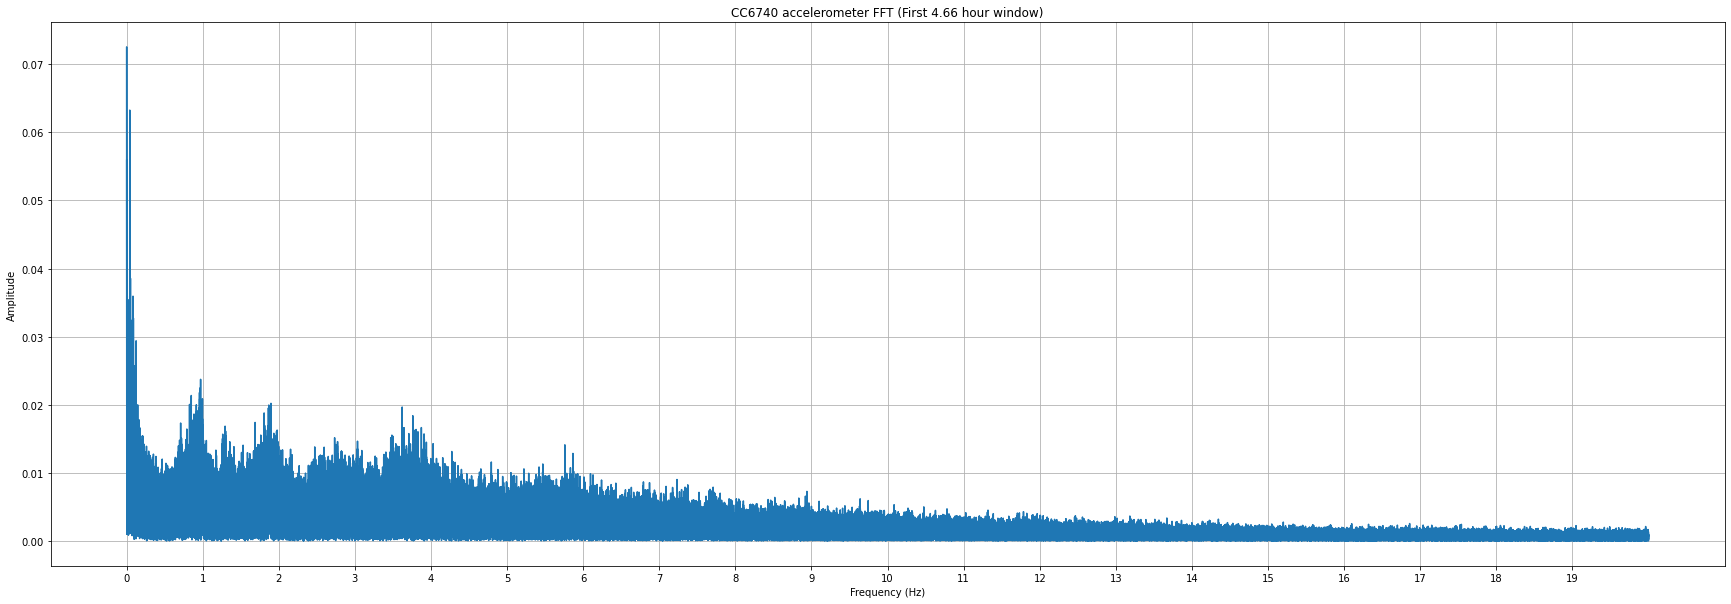

In [29]:
next_non_sober_start = accelerometer_data[pids[2]]['ground_truth'].where(accelerometer_data[pids[2]]['ground_truth'] == 0).idxmax()
sober_end = next_non_sober_start - 1
sampling_freq = 40
start_time = 2 * 60 * 60

l = accelerometer_data[pids[2]].shape[0]
x_window = accelerometer_data[pids[2]]['x'][start_time * sampling_freq:sober_end].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (First {(sober_end - start_time * sampling_freq) / (sampling_freq * 60 * 60):.2f} hour window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

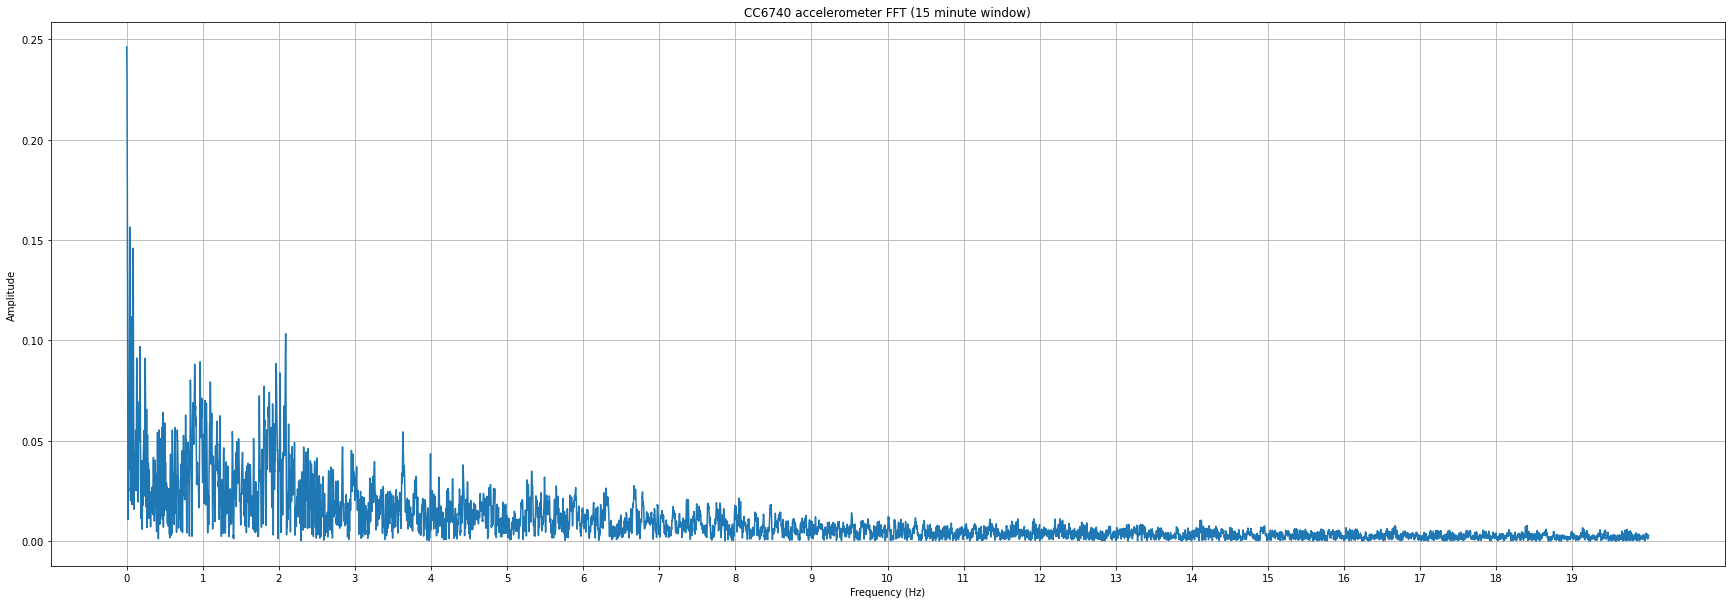

In [30]:
sampling_freq = 40
window_size = 15 * 60
start_time = 2 * 60 * 60

x_window = accelerometer_data[pids[2]]['x'][start_time:start_time + sampling_freq * window_size].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (15 minute window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

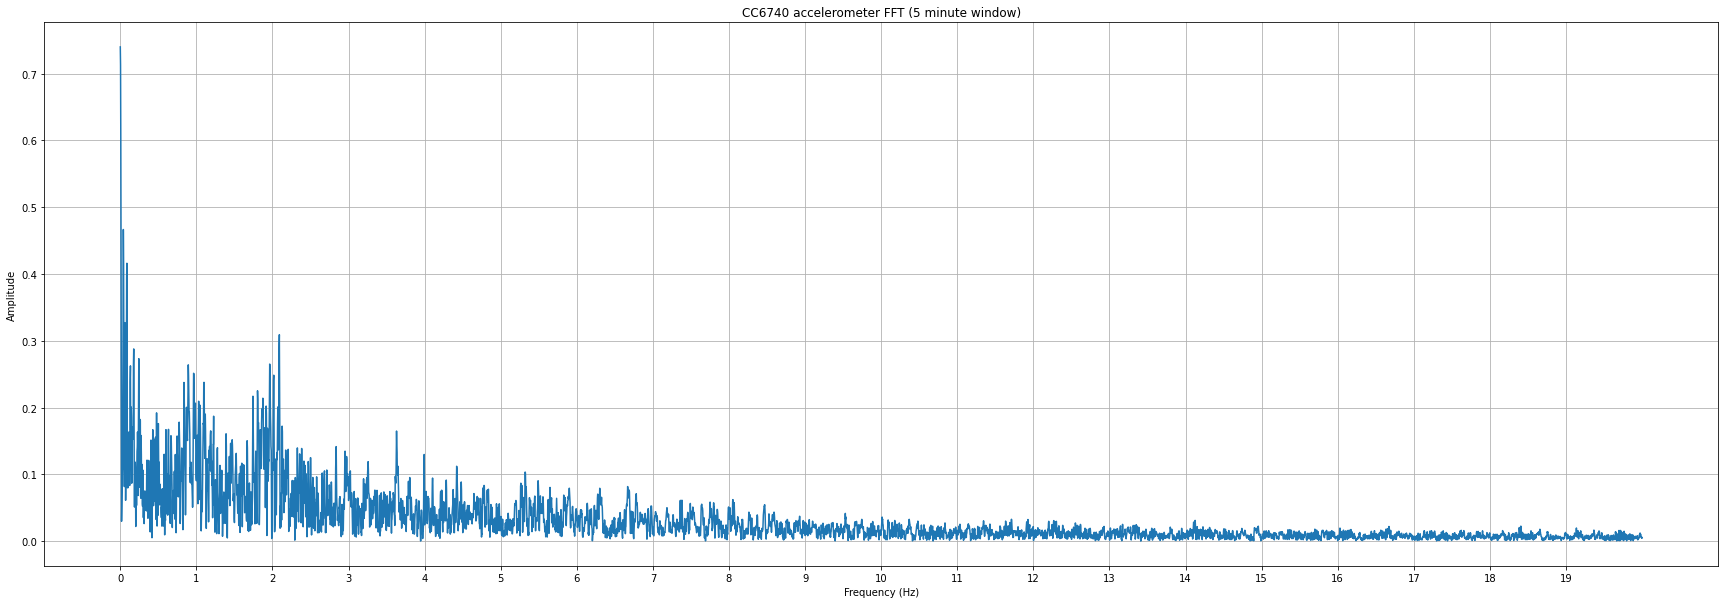

In [31]:
sampling_freq = 40
window_size = 5 * 60
start_time = 2 * 60 * 60

x_window = accelerometer_data[pids[2]]['x'][start_time:start_time + sampling_freq * window_size].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (5 minute window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

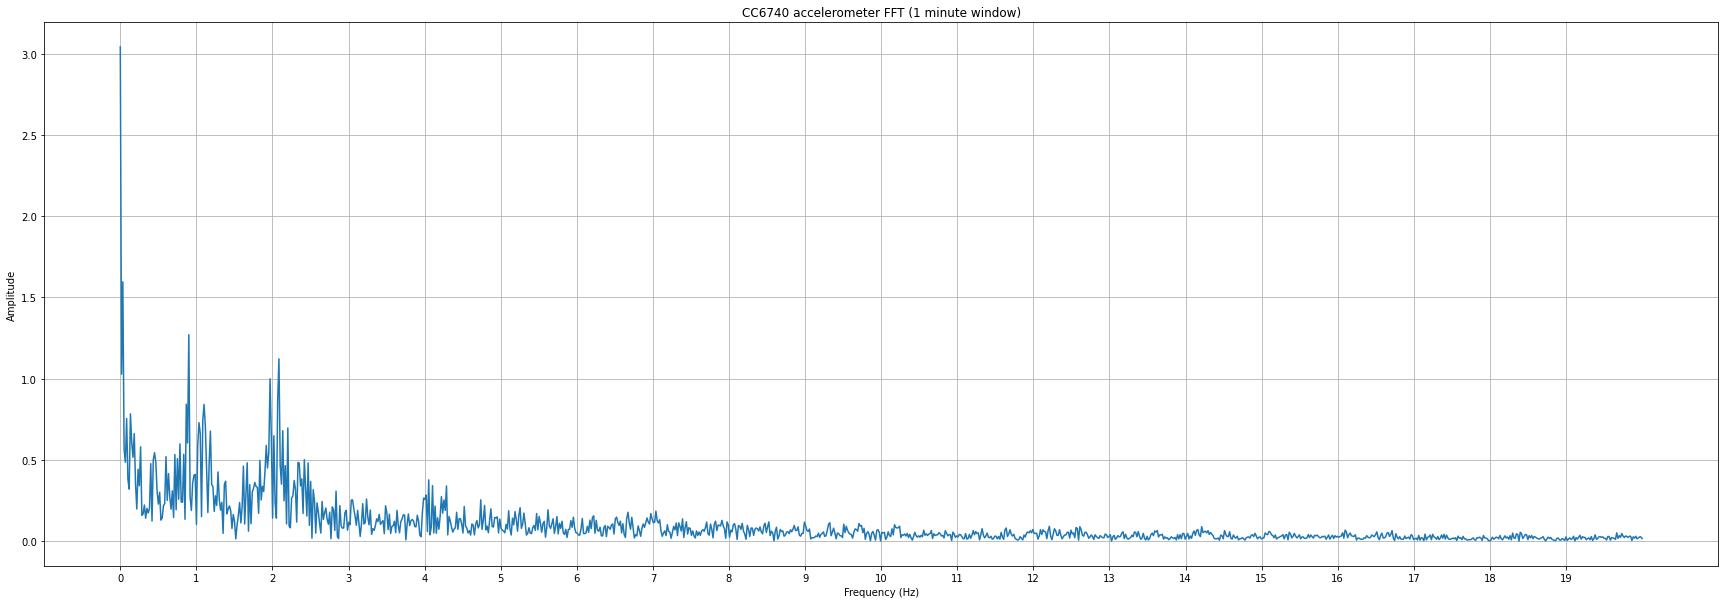

In [32]:
sampling_freq = 40
window_size = 1 * 60
start_time = 2 * 60 * 60

x_window = accelerometer_data[pids[2]]['x'][start_time:start_time + sampling_freq * window_size].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (1 minute window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

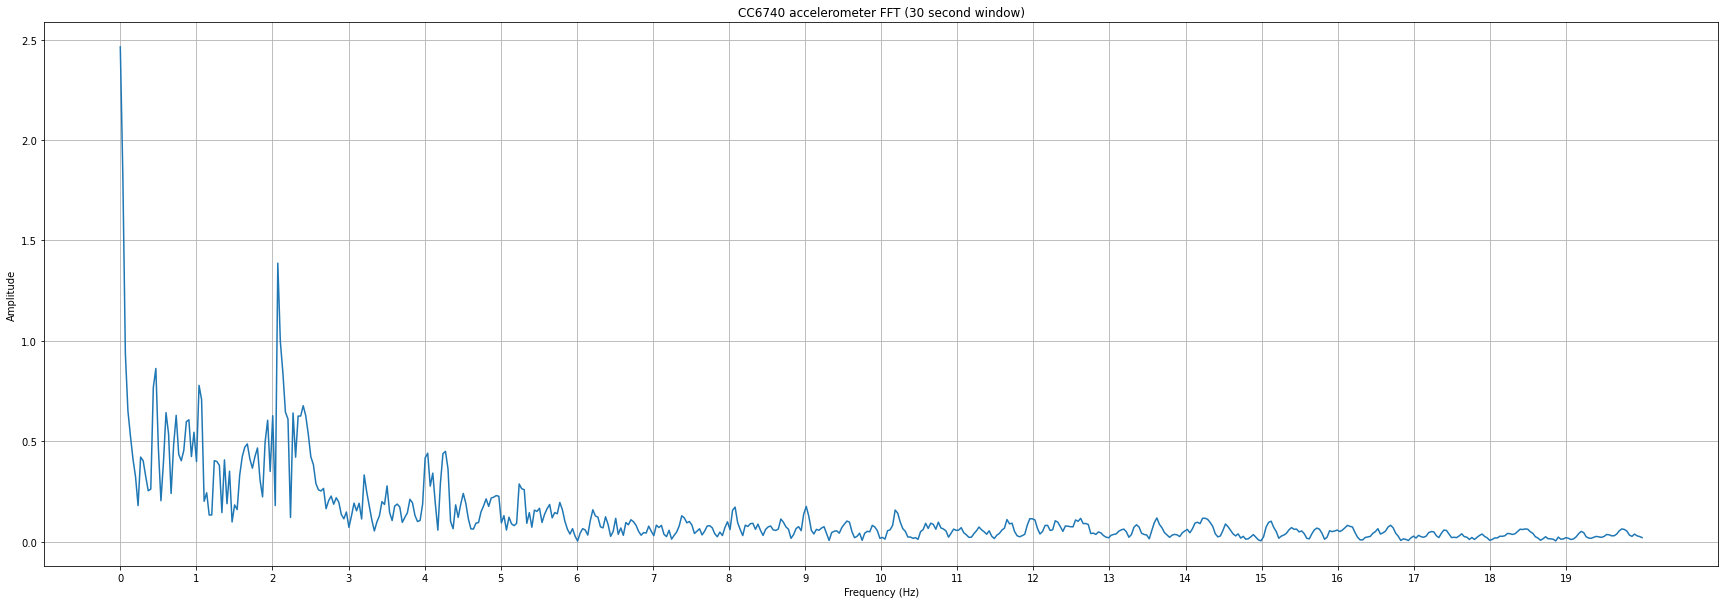

In [33]:
sampling_freq = 40
window_size =  30
start_time = 2 * 60 * 60

x_window = accelerometer_data[pids[2]]['x'][start_time:start_time + sampling_freq * window_size].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (30 second window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

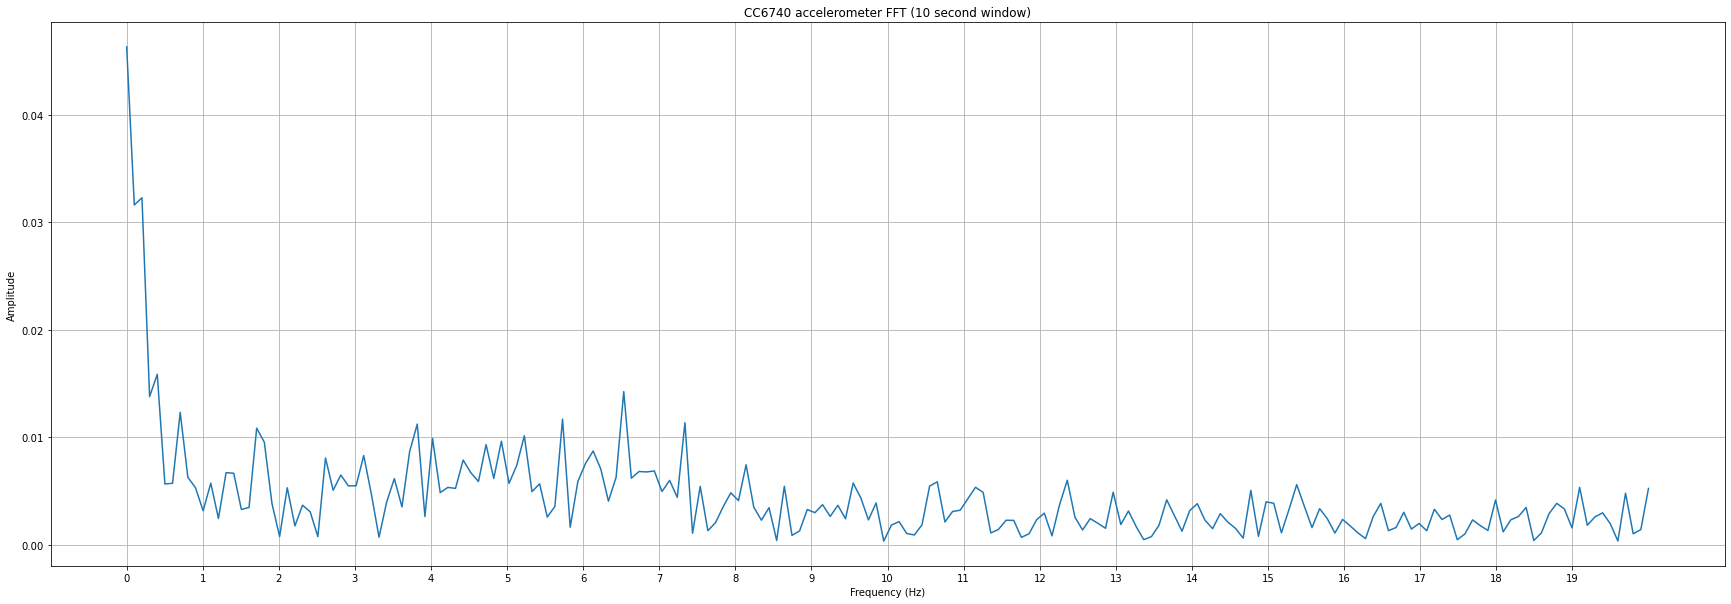

In [34]:
sampling_freq = 40
window_size = 10
start_time = 2 * 60 * 60

x_window = accelerometer_data[pids[2]]['x'][start_time:start_time + sampling_freq * window_size].to_numpy()
acc_x_fft = fftpack.fft(x_window)
freqs = (40 / 2) * np.linspace(0, 1, x_window.shape[0] // 2)
plt.figure(figsize=(30, 10))
plt.plot(freqs, (2 / x_window.shape[0]) * np.abs(acc_x_fft[:freqs.shape[0]]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'{pids[2]} accelerometer FFT (10 second window)')
plt.xticks(np.arange(0, 20, 1))
plt.grid()

By observing the frequency spectrums, clearly walking is involved. But the frequency content near 2Hz is less than the non sober windows. => Drunk walking frequency is less than normal walking frequency ????

## Data Cleaning

In [35]:
if not os.path.exists(f'{DATASET_PATH}/clean_participant_data'):
    os.makedirs(f'{DATASET_PATH}/clean_participant_data')
else:
    for file in os.listdir(f'{DATASET_PATH}/clean_participant_data'):
        os.remove(f'{DATASET_PATH}/clean_participant_data/{file}')

for acc_data in tqdm(os.listdir(f'{DATASET_PATH}/participant_data'), desc='Cleaning accelerometer data'):
    pid = acc_data.split('_')[0]
    data = pd.read_csv(f'{DATASET_PATH}/participant_data/{acc_data}')
    sos = signal.cheby2(15, 40, 3, 'low', fs=40, output='sos')
    # Apply chebyshev type II filters of 15th order with 3Hz stopband to three axes
    data['x'] = signal.sosfilt(sos, data['x'])
    data['y'] = signal.sosfilt(sos, data['y'])
    data['z'] = signal.sosfilt(sos, data['z'])
    data.to_csv(f'{DATASET_PATH}/clean_participant_data/{acc_data}')

Cleaning accelerometer data: 100%|██████████| 13/13 [02:20<00:00, 10.82s/it]


## Data Segmentation

Extract participant-wise accelerometer data + groundtruth labels.

In [125]:
accelerometer_data = {}

for acc_data in os.listdir(f'{DATASET_PATH}/clean_participant_data'):
    accelerometer_data[acc_data.split('_')[0]] = pd.read_csv(f'{DATASET_PATH}/clean_participant_data/{acc_data}', index_col=[0])

In [126]:
if not os.path.exists(f'{DATASET_PATH}/segmented_participant_data'):
    os.makedirs(f'{DATASET_PATH}/segmented_participant_data')
else:
    for file in os.listdir(f'{DATASET_PATH}/segmented_participant_data'):
        os.remove(f'{DATASET_PATH}/segmented_participant_data/{file}')

for pid, data in accelerometer_data.items():
    # A long segment is of 10 seconds and a short segment is of 1 second
    # Short segments are sub-segments of the long segments in order to calculate features from a two-tiered approach
    long_seg_id, short_seg_id = 0, 0
    data['long_seg'] = 0
    data['short_seg'] = 0
    # strptime -> parse formatted string to datetime object
    # strftime -> format datetime object to string
    start_time = datetime.strptime(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(data['timestamp'][0] / 1000)), '%Y-%m-%d %H:%M:%S')
    short_seg_start, long_seg_start = start_time, start_time
    short_delta, long_delta = timedelta(seconds=1), timedelta(seconds=10)
    for i, row in tqdm(data.iterrows(), desc=f'Segmenting {pid}', total=len(data)):
        # Current timestamp
        timestamp = datetime.strptime(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(row['timestamp'] / 1000)), '%Y-%m-%d %H:%M:%S')
        # When the current timestamp is greater or equal to the start of the current 10 second window + 10 seconds, we start a new 10 second window
        if timestamp >= long_seg_start + long_delta:
            # 🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴 SHOULD BE REVIEWED 🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴
            # If we couldn't find 10 short segments in the current 10 second window, should we drop the current 10 second window? -> Will reduce the number of rows in the final dataset
            # Or should we try to find the rest of the 10 short segments in the next 10 second window? -> Won't be a big problem while training, but will be a problem for inferencing
            # ➡️For now, let's drop the current 10 second window (I assume this is the best option) -> Mark them as -1
            if short_seg_id < 9:
                start_id = data.index[data['timestamp'] // 1000 == int(time.mktime(long_seg_start.timetuple()))][0]
                end_id = i
                data.loc[data.index[start_id:end_id], 'long_seg'] = -1
                long_seg_id -= 1
            # Start of a new long segment
            long_seg_id += 1
            short_seg_id = 0
            long_seg_start = timestamp
            short_seg_start = long_seg_start
        # When the current timestamp is greater or equal to the start of the current 1 second window + 1 second, we start a new 1 second window
        if timestamp >= short_seg_start + short_delta:
            short_seg_id += 1
            short_seg_start = timestamp
        # Update the current long segment
        data.at[i, 'long_seg'] = long_seg_id
        # Update the current short segment
        data.at[i, 'short_seg'] = short_seg_id
    if short_seg_id < 9:
        start_id = data.index[data['timestamp'] // 1000 == int(time.mktime(long_seg_start.timetuple()))][0]
        end_id = len(data)
        data.loc[data.index[start_id:end_id], 'long_seg'] = -1

    data.to_csv(f'{DATASET_PATH}/segmented_participant_data/{pid}_segmented.csv', index=False)
    print(f'{long_seg_id + 1} windows extracted for {pid}')

Segmenting BK7610: 100%|██████████| 1225727/1225727 [05:47<00:00, 3523.92it/s]


3068 windows extracted for BK7610


Segmenting BU4707: 100%|██████████| 447423/447423 [02:06<00:00, 3548.29it/s]


1119 windows extracted for BU4707


Segmenting CC6740: 100%|██████████| 2374694/2374694 [12:05<00:00, 3271.16it/s]


5527 windows extracted for CC6740


Segmenting DC6359: 100%|██████████| 591358/591358 [02:22<00:00, 4148.70it/s]


1546 windows extracted for DC6359


Segmenting DK3500: 100%|██████████| 1339622/1339622 [06:42<00:00, 3330.84it/s]


3364 windows extracted for DK3500


Segmenting HV0618: 100%|██████████| 1876013/1876013 [09:09<00:00, 3411.66it/s]


4702 windows extracted for HV0618


Segmenting JB3156: 100%|██████████| 1177748/1177748 [06:03<00:00, 3236.72it/s]


2042 windows extracted for JB3156


Segmenting JR8022: 100%|██████████| 307526/307526 [01:18<00:00, 3906.79it/s]


767 windows extracted for JR8022


Segmenting MC7070: 100%|██████████| 318600/318600 [01:15<00:00, 4199.32it/s]


796 windows extracted for MC7070


Segmenting MJ8002: 100%|██████████| 631303/631303 [02:33<00:00, 4119.97it/s]


1578 windows extracted for MJ8002


Segmenting PC6771: 100%|██████████| 2141701/2141701 [09:58<00:00, 3580.06it/s]


5357 windows extracted for PC6771


Segmenting SA0297: 100%|██████████| 962901/962901 [03:39<00:00, 4381.89it/s]


4361 windows extracted for SA0297


Segmenting SF3079: 100%|██████████| 662949/662949 [02:41<00:00, 4111.46it/s]


1660 windows extracted for SF3079


## Feature Extraction

For each axis, we will use a set of statistical metrics as well as some spectral features per window of 10 seconds in length. The window size is chosen arbitrarily and has to be tuned for the optimal value. The idea is to subdivide a window further into smaller windows of 1 second each and compute the metrics for each short-term window (this is also known as the two-tiered window approach) to characterize the data as it changes with time. Then, we'll compute the mean, variance, min and max along with the mean of the lower third and upper third of sorted values, creating a total of 6 summary statistics per metric per 10 second window per axis that results in 18 features per metric in total. We'll also calculate the difference between the previous window and the current window for each feature which will double the number of features per window per metric (36).

The feature extraction is done per participant data with the intention of splitting the data into training and test sets by participant. To keep the most relevant features, we will calculate the feature importance of each feature by converting the feature selection problem into a supervised learning problem. The traditional way of doing feature selection is computing the correlation between the features and removing one of highly correlated pairs of features and keeping the other. However, when there're many features, this approach is not feasible. Hence, we will use a Random Forest regressor to compute the feature importance. To select features automatically, we will use Recursive Feature Elimination (RFE) that'll use the random forest regressor as the predictive model to weight features and prune those with the smallest weights.

In [3]:
def zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data)))) / (2 * (len(data) - 1))

def spectral_entropy(signal, n_short_blocks=10, eps=1e-9):
    """Computes the spectral entropy"""
    # number of frame samples
    num_frames = len(signal)
    # total spectral energy
    total_energy = np.sum(signal ** 2)
    # length of sub-frame
    sub_win_len = int(np.floor(num_frames / n_short_blocks))
    if num_frames != sub_win_len * n_short_blocks:
        signal = signal[0:sub_win_len * n_short_blocks]
    # define sub-frames (using matrix reshape)
    sub_wins = signal.reshape(sub_win_len, n_short_blocks, order='F').copy()
    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (total_energy + eps)
    # compute spectral entropy
    entropy = -np.sum(s * np.log2(s + eps))
    return entropy

def spectral_centroid(fft_magnitude, sampling_rate=40, eps=1e-9):
    ind = (np.arange(1, len(fft_magnitude) + 1)) * (sampling_rate / (2.0 * len(fft_magnitude)))
    Xt = fft_magnitude.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps
    # Centroid:
    centroid = (NUM / DEN)
    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    return centroid

def spectral_spread(fft_magnitude, sampling_rate=40, eps=1e-9):
    ind = (np.arange(1, len(fft_magnitude) + 1)) * (sampling_rate / (2.0 * len(fft_magnitude)))
    Xt = fft_magnitude.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps
    # Spread:
    spread = np.sqrt(np.sum(((ind - (NUM / DEN)) ** 2) * Xt) / DEN)
    # Normalize:
    spread = spread / (sampling_rate / 2.0)
    return spread

def spectral_flux(fft_magnitude, previous_fft_magnitude, eps=1e-9):
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + eps)
    previous_fft_sum = np.sum(previous_fft_magnitude + eps)
    sp_flux = np.sum((fft_magnitude / fft_sum - previous_fft_magnitude / previous_fft_sum) ** 2)
    return sp_flux

def spectral_rolloff(signal, c=0.90, eps=1e-9):
    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Find the spectral rolloff as the frequency position where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + eps
    a = np.nonzero(cumulative_sum > threshold)[0]
    sp_rolloff = 0.0
    if len(a) > 0: sp_rolloff = np.float64(a[0]) / (float(fft_length))
    return sp_rolloff

def spectral_peak_ratio(fft_magnitude, eps=1e-9):
    # Ratio of largest peak to second largest peak
    peaks = sorted(fft_magnitude, reverse=True)
    if len(peaks) < 2: return 0.0
    return peaks[0] / (peaks[1] + eps)

def max_frequency(fft_magnitude, sampling_rate=40):
    max_freq = np.argmax(fft_magnitude)
    max_freq *= (sampling_rate / (2.0 * len(fft_magnitude)))
    return max_freq

def mfcc_filter_banks(sampling_rate, num_fft, lowfreq=133.33, linc=200 / 3,
                      logsc=1.0711703, num_lin_filt=13, num_log_filt=27):
    """
    Computes the triangular filterbank for MFCC computation 
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    if sampling_rate < 8000:
        nlogfil = 5

    # Total number of filters
    num_filt_total = num_lin_filt + num_log_filt

    # Compute frequency points of the triangle:
    frequencies = np.zeros(num_filt_total + 2)
    frequencies[:num_lin_filt] = lowfreq + np.arange(num_lin_filt) * linc
    frequencies[num_lin_filt:] = frequencies[num_lin_filt - 1] * logsc ** \
                                 np.arange(1, num_log_filt + 3)
    heights = 2. / (frequencies[2:] - frequencies[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((num_filt_total, num_fft))
    nfreqs = np.arange(num_fft) / (1. * num_fft) * sampling_rate

    for i in range(num_filt_total):
        low_freqs = frequencies[i]
        cent_freqs = frequencies[i + 1]
        high_freqs = frequencies[i + 2]

        lid = np.arange(np.floor(low_freqs * num_fft / sampling_rate) + 1,
                        np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        lslope = heights[i] / (cent_freqs - low_freqs)
        rid = np.arange(np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        np.floor(high_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        rslope = heights[i] / (high_freqs - cent_freqs)
        fbank[i][lid] = lslope * (nfreqs[lid] - low_freqs)
        fbank[i][rid] = rslope * (high_freqs - nfreqs[rid])

    return fbank, frequencies

def mfcc(fft_magnitude, fbank, num_mfcc_feats, eps=1e-9):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        fft_magnitude:  fft magnitude abs(FFT)
        fbank:          filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:           MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the 
             scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more 
         compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = np.log10(np.dot(fft_magnitude, fbank.T) + eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:num_mfcc_feats]
    return ceps

def avg_power(sig):
    _, power = signal.welch(sig, 40, nperseg=len(sig))
    return np.mean(power)

def rms(signal):
    return np.sqrt(np.mean(signal ** 2))

In [8]:
if not os.path.exists(f'{DATASET_PATH}/feature_data'):
    os.makedirs(f'{DATASET_PATH}/feature_data')
else:
    for file in os.listdir(f'{DATASET_PATH}/feature_data'):
        os.remove(f'{DATASET_PATH}/feature_data/{file}')

In [9]:
metrics = {
    'mean': np.mean, 
    'std': np.std,
    'avg_abs_dev': lambda x: np.mean(np.abs(x - np.mean(x))),
    'min_raw': np.min,
    'max_raw': np.max,
    'min_abs': lambda x: np.min(np.abs(x)),
    'max_abs': lambda x: np.max(np.abs(x)), 
    'median': np.median, 
    'inter_quartile_range': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
    'zero_crossing_rate': zero_crossing_rate, 
    'skewness': skew, 
    'kurtosis': kurtosis, 
    'spectral_entropy': spectral_entropy, 
    'fft_spectral_entropy': spectral_entropy,
    'fft_spectral_centroid': spectral_centroid, 
    'fft_spectral_spread': spectral_spread,
    'fft_spectral_rolloff': spectral_rolloff,
    'fft_spectral_peak_ratio': spectral_peak_ratio,
    'avg_power': avg_power,
    'rms': rms,
    'max_freq': max_frequency
    # TODO: #6 The metrics "spectral_flux" and "mfcc" require the window sizes to be equal
    # 'fft_spectral_flux': spectral_flux,
    # 'fft_mfcc', 
}

n_mfcc_features = 13

summary_stats = {
    'mean': np.mean,
    'variance': np.var,
    'min': np.min,
    'max': np.max,
    'lower_third_mean': lambda x: np.mean(sorted(x)[:len(x) // 3]),
    'upper_third_mean': lambda x: np.mean(sorted(x)[len(x) // 3:])
}

for acc_data in os.listdir(f'{DATASET_PATH}/segmented_participant_data'):
    pid = acc_data.split('_')[0]
    data = pd.read_csv(f'{DATASET_PATH}/segmented_participant_data/{acc_data}')
    feature_df = pd.DataFrame()
    columns = []
    ground_truth = []
    for long_seg_id, long_seg in tqdm(data.groupby(['long_seg']), desc=f'Extracting features for {pid}', total=len(data['long_seg'].unique())):
        if long_seg['long_seg'].unique()[0] == -1: continue
        short_segs = [short_seg for _, short_seg in long_seg.groupby(['short_seg'])]
        short_seg_fft_mag = [{axis: np.abs(fftpack.fft(seg[axis].to_numpy())) for axis in ['x', 'y', 'z']} for seg in short_segs]
        row = []
        bad_seg = False
        for metric_name, metric in metrics.items():
            # Compute the metric for each short segment
            short_term_features = {'x': [], 'y': [], 'z': []}

            def apply_metric(seg_id, axis):
                if metric_name.split('_')[0] != 'fft':
                    return metric(short_segs[seg_id][axis].to_numpy())
                if metric_name == 'fft_spectral_flux':
                    fft_mag_prev = short_seg_fft_mag[seg_id - 1][axis] if seg_id > 0 else short_seg_fft_mag[seg_id][axis]
                    return metric(short_seg_fft_mag[seg_id][axis], fft_mag_prev)
                return metric(short_seg_fft_mag[seg_id][axis])
            
            for short_seg_id in range(10):
                if len(short_segs[short_seg_id]) <= 1:
                    bad_seg = True
                    break
                short_term_features['x'].append(apply_metric(short_seg_id, 'x'))
                short_term_features['y'].append(apply_metric(short_seg_id, 'y'))
                short_term_features['z'].append(apply_metric(short_seg_id, 'z'))

            if bad_seg: break
            
            # Now compute the summary statistics for the metric for the current long segment
            for axis, axis_data in short_term_features.items():
                for summary_stat_name, summary_stat in summary_stats.items():
                    row.append(summary_stat(axis_data))
                    if long_seg_id == 0:
                        columns.append(f'{axis}_{metric_name}_{summary_stat_name}')

        if bad_seg: continue

        ground_truth.append(long_seg['ground_truth'].value_counts().idxmax())

        temp = row
        if long_seg_id == 0:
            columns.extend([f'{feature_name}_diff' for feature_name in columns])
            feature_df = pd.DataFrame(columns=columns)
            row *= 2
        else:
            row.extend([row[i] - prev_row[i] for i in range(len(row))])
        feature_df.loc[long_seg_id] = row
        prev_row = temp
    feature_df['ground_truth'] = ground_truth
    feature_df.to_csv(f'{DATASET_PATH}/feature_data/{pid}.csv', index=False)

Extracting features for SF3079: 100%|██████████| 1660/1660 [02:26<00:00, 11.36it/s]
